First we import our dependencies.

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip

We import our data into a dictionary, the keys of which describe the splitting.

In [2]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [3]:
def format_fn(path):
    '''
    Formats single-channel image (.png) at path as a tf.Tensor of shape suitable 
    for input to a CNN.
    
    Args:
        path (str): Image filepath.
        
    Returns:
        tf.Tensor: formatted tensor representing the image.
    '''
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path, pixels=pixels):
    '''
    Formats x and y single-channel images (.png) as tf.Tensors of shape suitable 
    for input to a CNN. Formatting of y images is performed by separating the pixel 
    values in pixels into discrete Boolean channels along the depth axis.
    
    Args:
        x_path (str): x image (raw input) filepath.
        y_path (str): y image (raw input) filepath.
        
    Returns:
        x (tf.Tensor): Formatted tensor representing the x image.
        y (tf.Tensor): Formatted tensor of Boolean channels representing the y image.
    '''
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [4]:
# Create the datasets for each element of the datasets list (train, validate, test), 
# storing them in data_dict.
for dataset in datasets:
    # Extract the x and y image titles; we know these to match and could generate them
    # from a single glob.glob if preferred. However, this method is useful as it allows 
    # us to check that no images are missing.
    x_paths = glob.glob(my_path + dataset + '/*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '/*.png')
    # Create a tf.data.Dataset from the image filepaths.
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    # Shuffle each dataset at each iteration to prevent data leakage, choosing a large 
    # Shuffling index to safeguard against only shuffling a small portion.
    data_dict[dataset] = data_dict[dataset].shuffle(10**5, reshuffle_each_iteration=True)
    # Apply the path_2_tens map, filling out the datasets.
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

Let's take a quick look to check things worked correctly.

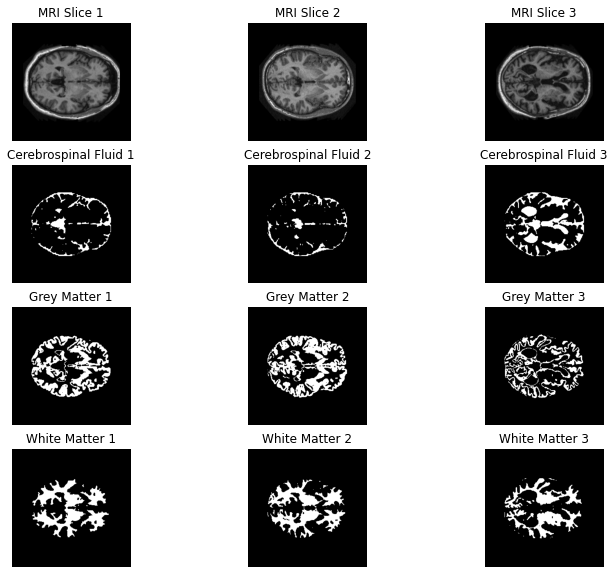

In [5]:
# Extract three samples from the training set using an iterator.
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
# The samples contain each image in the first dimension, the two pixel  
# axes in the second and third dimensions and the channels in the
# fourth dimension. Here we do not require the channel on the x image.
x_sample = tf.reshape(x_sample, [3, 256, 256])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

# For each sample we plot the x image as well as each formatted channel 
# of the y image, making use of the product function from itertools 
# (here renamed myzip in comparison with the standard zip tool).
for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

Now we build our subclassed layers:

In [22]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, activation=True, strides=(1, 1), kernel=3, \
            alpha=10^-2, initializer=tf.keras.initializers.he_uniform(), \
            regularizer=tf.keras.regularizers.l2(10^-2)):
        '''
        Inherits from tf.keras.layers.Layer, consists of a 3X3 convolution of 
        variable stride passing to an optional batch normalization and activation 
        (tf.keras.layers.LeakyReLU).
        
        Args:
            filters (int): Number of convolutional filters.
            activation (bool): Whether or not to include activation.
            strides (tuple): Stride in each dimension.
            kernel (int): Square filter side length.
            alpha (float): Gradient of tf.keras.layers.LeakyReLU below activation.
            initializer (tf.keras.initializers): Initialization algorithm, set to 
            he_uniform for ReLU based activations or glorot_uniform for others.
            kernel_regularizer (tf.keras.regularizers): Regularization algorithm, not 
            implemented here but optional for future tasks.
        '''
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, strides=strides, \
           padding='same', kernel_initializer=initializer)
        self.activation = activation
        if self.activation:
            self.batchnorm_1 = tf.keras.layers.BatchNormalization()
            self.leakyrelu_1 = tf.keras.layers.LeakyReLU(alpha=alpha)
        
    def call(self, x):
        '''
        Defines the forward pass.
        
        Args:
            x (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
        '''
        x = self.conv2d_1(x)
        if self.activation:
            x = self.batchnorm_1(x)
            x = self.leakyrelu_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):

    def __init__(self, filters, bottom=False, dropout=0.3):
        '''
        Inherits from tf.keras.layers.Layer, consists of a residual context module 
        passing to a stride 2X2 MyConv2D layer. The residual context module contains 
        two My_Conv2D layers, the first without activation, separated by dropout. 
        The initial tensor is then added element-wise to the output before being 
        stored as x_res and passed to the stride 2X2 convolution with twice as many 
        filters; x_res is later employed for context aggregation by Upshift. An option 
        to not compute the stride 2X2 convolution is included so that the UNet 
        architecture can effectively 'bottom out'. Combining the residual context module 
        with the stride 2X2 convolution in this way is useful for fast prototyping with 
        small networks as these converge much more quickly than larger equivalents, 
        offering a proof of concept.

        Args:
            filters (int): Number of filters to be used in each convolutional layer of 
                the residual context module.
            bottom (bool): Whether or not to 'bottom out' by not including the stride 
                2X2 convolution.
            dropout (float): Dropout probability.
        '''
        
        super(Downshift, self).__init__()
        self.bottom = bottom
        
        self.conv2d_1 = My_Conv2D(filters, activation=False)
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.conv2d_2 = My_Conv2D(filters)
        self.add_1 = tf.keras.layers.Add()
        self.conv2d_3 = My_Conv2D(int(filters * 2), strides=(2, 2))
        
    def call(self, x_init):
        '''
        Defines the forward pass.
        
        Args:
            x_init (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        If self.bottom is not true:
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
                
        If self.bottom is true:
        
        Returns:
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
        '''
        x = self.conv2d_1(x_init)
        x = self.dropout_1(x)
        x = self.conv2d_2(x)
        x_res = self.add_1([x, x_init])
        
        if self.bottom:
            return x_res
        else:
            x = self.conv2d_3(x)

            return x, x_res
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, filters, top=False):
        '''
        Inherits from tf.keras.layers.Layer, consists of an upsampling module passing 
        to a localization module. The upsampling module contains an upsampling layer 
        which doubles the instance of each pixel in each dimension prior to an 
        activated My_Conv2D layer which halves the feature space. Output from the 
        upsampling module then enters the localization module, where it is concatenated 
        with the x_res output from the Downshift layer of corresponding feature space 
        before a 3X3 My_Conv2D passing to a 1X1 My_Conv2D which again halves the feature 
        space. This tensor is then outputted, in addition to a segmented copy for later 
        context aggregation. As with Downshift, an option is included to bypass the 
        segmentation so that the UNet can effectively 'top out'. Again, combining the 
        upsampling and localization modules is useful for fast prototyping with small 
        networks.

        Args:
            filters (int): Number of filters to be used in each convolutional layer prior 
            to the 1X1 My_Conv2D layer.
            top (bool): Whether or not to 'top out' by not including the segmentation.
        '''
        super(Upshift, self).__init__()
        self.top = top
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(int(filters / 2), kernel=1)
        self.seg_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, X):
        '''
        Defines the forward pass.
        
        Args:
            X (tf.Tensor, tf.Tensor): Image tensors x_i and x_j_res; x_i is the output from 
            the previous layer while x_j_res is the residual produced by the Downshift layer 
            of corresponding feature space.
            
        If self.top is not true:
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
            x_seg (tf.Tensor): Image tensor as processed by the layer, also segmented.
                
        If self.top is true:
        
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
        '''
        x, x_res = X
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([x, x_res])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x_seg = self.seg_1(x)
        
        if self.top:
            return x_seg
        
        else:
            return x, x_seg

From which we create a subclassed model.

In [23]:
class My_UNet(tf.keras.Model):
    def __init__(self, input_img_shape):
        '''
        Inherits from tf.keras.Model, consists of an initival MyConv2D with activation 
        passing to consecutive Downshift layers (here 5). These 'bottom out' before 
        entering a sequence of Upshift layers corresponding to the Downshifts. A context 
        aggregation pathway is attached to the Upshift sequence consisting of upsampled 
        segmentations from each Upshift layer, these being consecutively added element-
        wise before being similarly combined with the output of the Upshifts. Finally, 
        this output is passed to a segmentation layer.
        
        Args:
            input_img_shape (x, y, channels): Input image shape, must remain fixed.
        '''
        super(My_UNet, self).__init__()
        self.input_img_shape = input_img_shape
        
        self.conv2d_1 = My_Conv2D(16)
        
        self.downshift_1 = Downshift(16)
        self.downshift_2 = Downshift(32)
        self.downshift_3 = Downshift(64)
        self.downshift_4 = Downshift(128)
        self.downshift_5 = Downshift(256, bottom=True)
        
        self.upshift_1 = Upshift(128)
        self.upshift_2 = Upshift(64)
        self.upshift_3 = Upshift(32)
        self.upshift_4 = Upshift(16, top=True)
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.add_1 = tf.keras.layers.Add()
        self.upsampling_2 = tf.keras.layers.UpSampling2D()
        self.add_2 = tf.keras.layers.Add()
        
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, x_0):
        '''
        Defines the forward pass.
        
        Args:
            x_0 (tf.Tensor): The input image.
            
        Returns:
            x_17 (tf.Tensor): Segmentation masks of the input image.
        '''
        x_1 = self.conv2d_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        x_4, x_4_res = self.downshift_3(x_3)
        x_5, x_5_res = self.downshift_4(x_4)
        x_6 = self.downshift_5(x_5)

        x_7, x_7_seg = self.upshift_1([x_6, x_5_res])
        x_8, x_8_seg = self.upshift_2([x_7, x_4_res])
        x_9, x_9_seg = self.upshift_3([x_8, x_3_res])
        x_10 = self.upshift_4([x_9, x_2_res])
        
        x_11 = self.upsampling_1(x_7_seg)
        x_12 = self.add_1([x_11, x_8_seg])
        x_13 = self.upsampling_1(x_12)
        x_14 = self.add_1([x_13, x_9_seg])
        x_15 = self.upsampling_2(x_14)
        x_16 = self.add_2([x_15, x_10])

        x_17 = self.output_1(x_16)
        
        return x_17
    
    def build_graph(self):
        '''
        Builds a shell of the model to implement summary and plotting functionality; 
        To emphasise the flexibility of the subclassing API, these functionalities of 
        Keras do not include native support for subclassed objects.
        
        Returns:
            tf.keras.Model: A model shell linking a defined input to the forward pass of 
            My_UNet.
        '''
        x_0 = tf.keras.Input(shape=self.input_img_shape)
        
        return tf.keras.Model(inputs=[x_0], outputs=self.call(x_0))

We implement our metric of performance and loss function:

In [8]:
def dice_coe(y_ground, y_predicted):
    '''
    Dice coefficient metric of performance, equivalent to 2 X IoU.
    
    Args:
        y_ground (tf.Tensor): Ground truth segmentation masks.
        y_predicted (tf.Tensor): Predicted segmentation masks.
        
    Returns:
        float: Dice coefficient of y_ground and y_predicted.
    '''
    intersection = backend.sum(y_ground * y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    
    return 2 * (intersection) / (union)

In [9]:
def smoothed_jaccard_distance(y_ground, y_predicted, smoothing=10):
    '''
    Jaccard distance loss function with added smoothing for numerical stability; 
    smoothing level can act as a hyperparameter but is mainly effective only where 
    batch normalisation has not been implemented.
    
    Args:
        y_ground (tf.Tensor): Ground truth segmentation masks.
        y_predicted (tf.Tensor): Predicted segmentation masks.
        
    Returns:
        float: Smoothed Jaccard distance of y_ground and y_predicted.
    '''
    intersection = backend.sum(y_ground*y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    jaccard_index = (intersection + smoothing)/(union - intersection + smoothing)
    
    return (1 - jaccard_index)*smoothing

Compile the model:

In [27]:
input_img_shape = (256, 256, 1)
model = My_UNet(input_img_shape)

# We know we will not need to train for long, so can implement a steeply 
# decreasing learning rate schedule.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    10**-3,
    decay_steps=8*10**2,
    decay_rate=0.9,
    staircase=True)

# The Adam optimizer provides stability not easily achievable with SGD etc.
my_opt = adam(learning_rate=lr_schedule)

model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance,
              metrics=[dice_coe])

model.build(input_shape=(None, *input_img_shape))

model.build_graph().summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
my__conv2d_196 (My_Conv2D)      (None, 256, 256, 16) 224         input_10[0][0]                   
__________________________________________________________________________________________________
downshift_35 (Downshift)        ((None, 128, 128, 32 9472        my__conv2d_196[0][0]             
__________________________________________________________________________________________________
downshift_36 (Downshift)        ((None, 64, 64, 64), 37376       downshift_35[0][0]               
____________________________________________________________________________________________

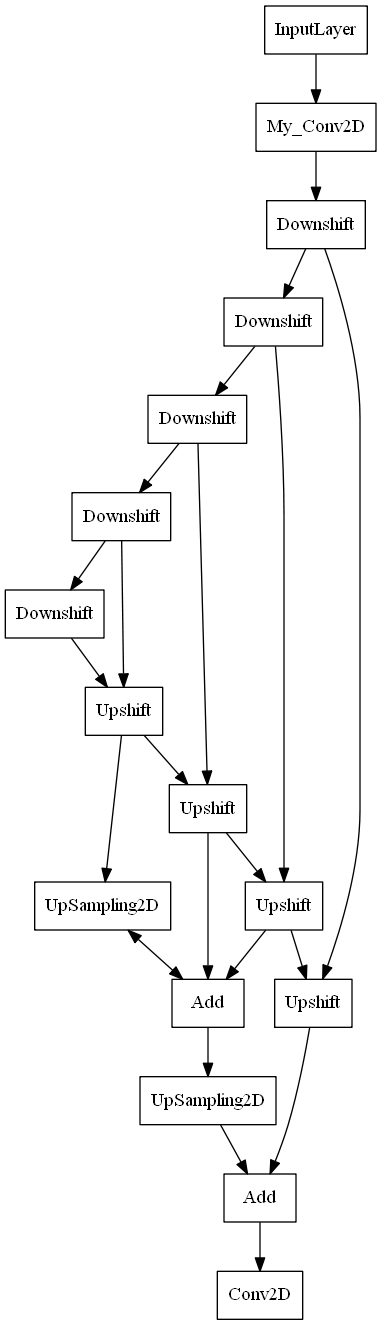

In [25]:
tf.keras.utils.plot_model(model.build_graph(), show_layer_names=False)

And begin training!

In [28]:
# We train for 5 epochs, noting that considerably smaller models (only two 
# Downshifts!) achieve similar results.
history = model.fit(data_dict['train'].batch(2), epochs=5,
                    validation_data=data_dict['validate'].batch(2), verbose=1)

Train for 4832 steps, validate for 560 steps
Epoch 1/5
4832/4832 [==============================] - 271s 56ms/step - loss: 1.8767 - dice_coe: 0.8800 - val_loss: 0.8575 - val_dice_coe: 0.9537
Epoch 2/5
4832/4832 [==============================] - 307s 63ms/step - loss: 0.7604 - dice_coe: 0.9592 - val_loss: 0.7735 - val_dice_coe: 0.9585
Epoch 3/5
4832/4832 [==============================] - 258s 53ms/step - loss: 0.6509 - dice_coe: 0.9653 - val_loss: 0.6601 - val_dice_coe: 0.9649
Epoch 4/5
4832/4832 [==============================] - 249s 52ms/step - loss: 0.6072 - dice_coe: 0.9678 - val_loss: 0.6209 - val_dice_coe: 0.9670
Epoch 5/5
4832/4832 [==============================] - 209s 43ms/step - loss: 0.5865 - dice_coe: 0.9689 - val_loss: 0.6014 - val_dice_coe: 0.9682


Let's visualise the performance:

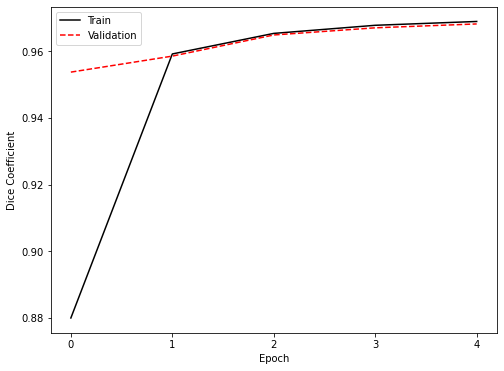

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['dice_coe'], 'k', label='Train')
ax.plot(history.history['val_dice_coe'], 'r--', label = 'Validation')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Coefficient')
ax.legend()

plt.show()

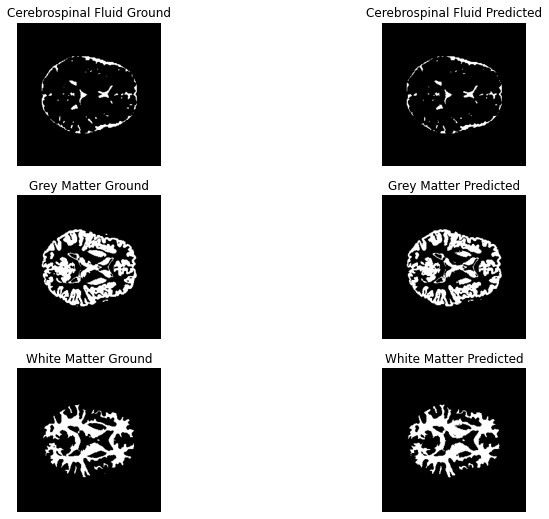

In [29]:
# Following our previous plotting example:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

In [30]:
# Finally we compute the dice coefficient on the test set.
model.evaluate(data_dict['test'].batch(2))

272/272 [==============================] - 16s 60ms/step - loss: 0.6904 - dice_coe: 0.9624


[0.690384070005487, 0.96240985]

Luckily for us, the model seems to generalise well.